## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

1. Oczyść dane i zaprezentuj rozkład klas

In [2]:
import pandas as pd
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('Stress.csv')
data

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005
...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [6]:
cols_to_drop = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df = data.drop(cols_to_drop,axis=1)
df.sample(5)

,text,label
1545,My son was septic with respiratory distress fo...,1
2038,As a native San Francisco we have lots of home...,0
1450,It was more calm then I had felt in months. Bu...,1
2050,"Now, this was my first long term serious relat...",0
747,"For the remaining money, it is going toward th...",0


In [7]:
df['label'].unique()

array([1, 0], dtype=int64)

In [8]:
df.groupby('label').nunique()

,text
label,
0,1338
1,1485


<AxesSubplot:xlabel='label', ylabel='count'>

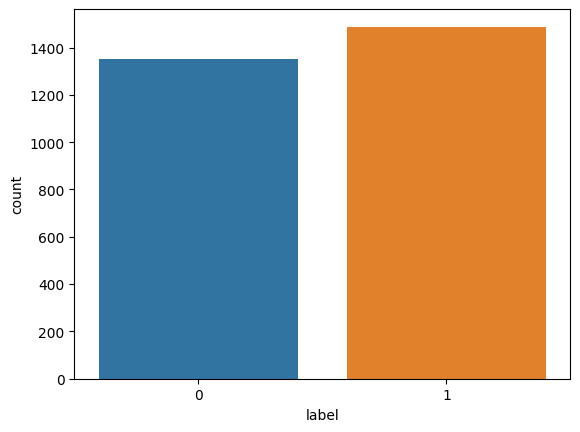

In [9]:
sns.countplot(x='label', data=df)

In [10]:
df['text'] = df['text'].apply(lambda x: x.lower())
df.sample(5)

,text,label
2513,the new man almost immediately moved to the fl...,0
2830,to me i feel like that is someone older than m...,0
1120,a little over two years ago i visited a psychi...,0
1898,"except now, the boyfriend's taken up drinking ...",1
1628,(mind you we are all here from dss/social serv...,1


In [11]:
re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
df['text'] = df['text'].apply(lambda x: re_url.sub('', x))

re_letter = re.compile(r"[^a-z\s']")
df['text'] = df['text'].apply(lambda x: re_letter.sub('', x))
df.sample(10)

,text,label
2335,is it more than that i have been considering f...,1
2087,three months of this and talking with the one ...,1
349,it happened in the fall of i was getting off ...,0
2264,it is the winter and tyler and i have been goi...,0
2567,i thought i did well but i was severely depres...,1
2643,she talked sarcastically about how my life is ...,0
355,hello my name is jake i am years old and i ne...,1
902,i also always bite and pick at my lips meaning...,1
2440,but one night i somehow picked up on a pattern...,1
2490,what if they were met with a broken system the...,0


In [12]:
!pip install -U spacy
!python -m spacy download en_core_web_md

     --------------------------------------- 42.8/42.8 MB 19.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [14]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [ ]:
nlp.Defaults.stop_words

In [16]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

df['text'] = df['text'].apply(remove_stopwords)
df.sample(10)

,text,label
1620,heavy periods seen far lasted weeks like girl ...,1
532,feel like let colleagues scared reprimanded th...,0
2087,months talking friend free pm att's gophone po...,1
1059,desperately needs oncologist tumors she's deve...,0
1698,fuck bitch life hell kicked manage place owner...,1
2349,tldr need apartment room rent deposit payment ...,0
591,what's best way hold couple days things able p...,0
2456,i'm scared i've edge past days th degree felon...,1
1221,hey folks greetings india friend school's fath...,0
962,context i'm working year grad school living cu...,1


In [17]:
df.drop_duplicates(subset='text', keep='first', inplace=True)

In [18]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

df['text'] = df['text'].progress_apply(lemmatize)
df.sample(10)

  0%|          | 0/2818 [00:00<?, ?it/s]

100%|██████████| 2818/2818 [00:28<00:00, 98.10it/s] 


,text,label
716,I ve come unglued absolutely past seize moment...,1
2217,like say work hard try well job balance school...,1
2648,wish list amazon expensive item create walmart...,0
1510,month ago see doctor go anti anxiety me genera...,1
1327,want successful networking form close friendsh...,1
2609,comfort able home break confronted brother beh...,0
2207,apparently new technology entire phone shut mi...,1
1519,admit night yes need mental assistance spendin...,0
162,couple fouryearold daughter live bedroom apart...,1
254,need motel need advice grandson end leave pres...,1


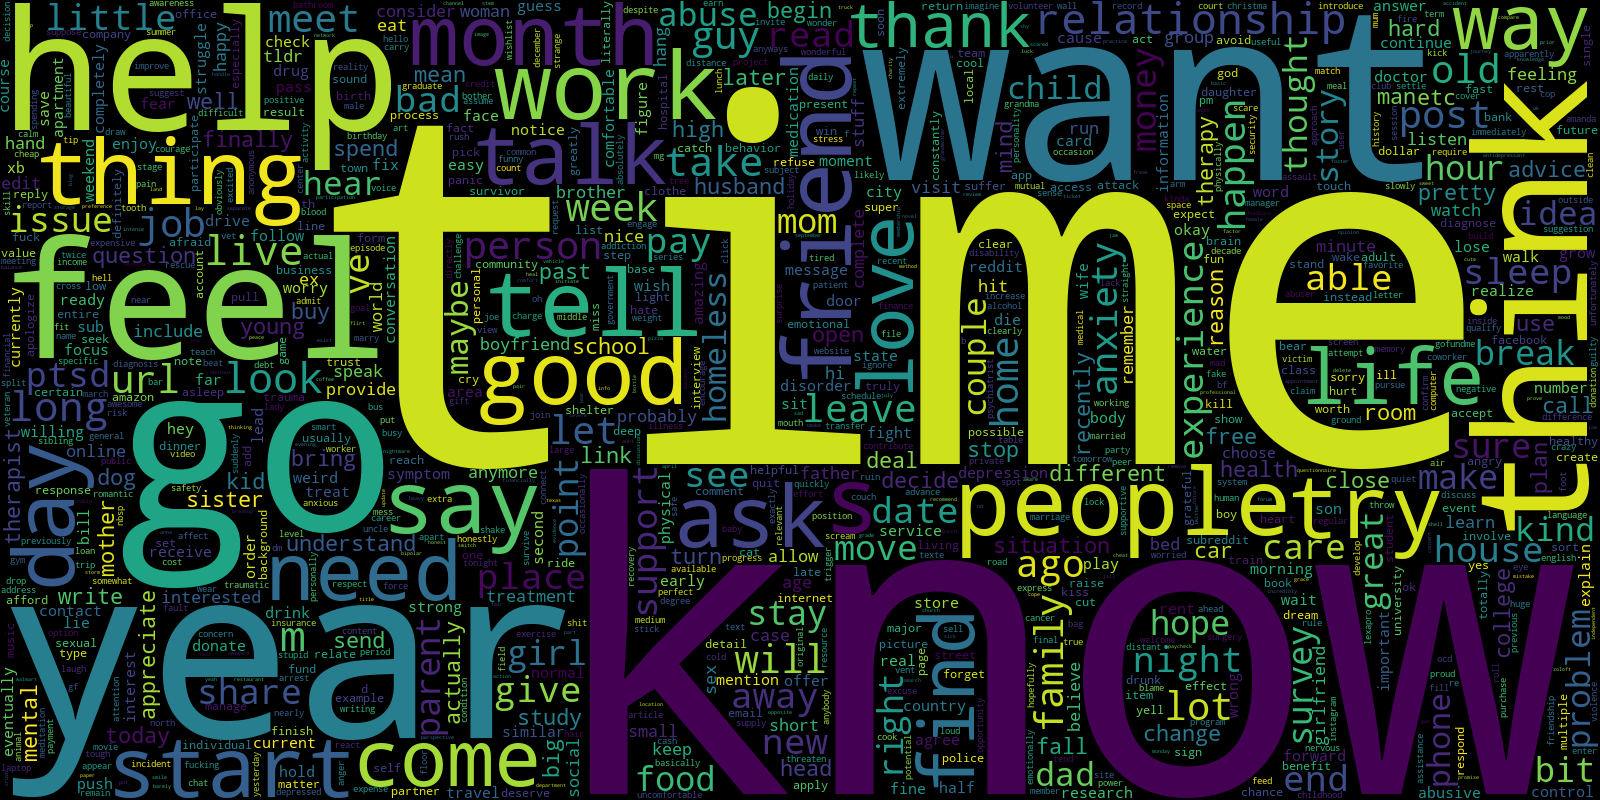

In [19]:
no_stress = ' '.join(df[df['label']==0]['text'])

wc_no_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(no_stress)
wc_no_stress.to_image()

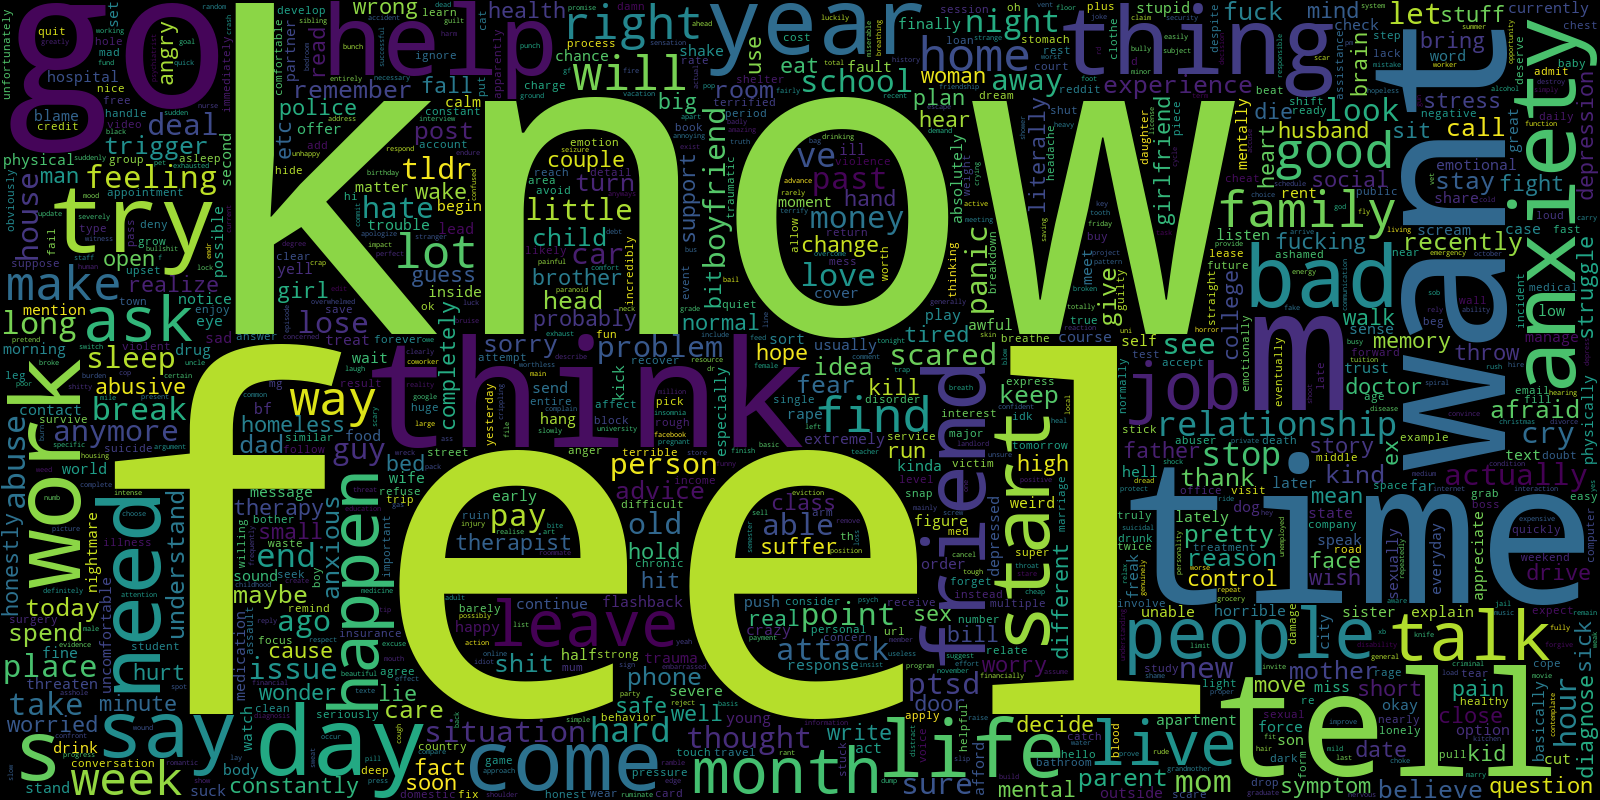

In [20]:
stress = ' '.join(df[df['label']==1]['text'])

wc_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(stress)
wc_stress.to_image()

2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.3, random_state=42)

In [23]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_val_tokens = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(seq) for seq in X_train_tokens)

X_train_tokens = pad_sequences(X_train_tokens, maxlen=max_len, padding='post')
X_val_tokens = pad_sequences(X_val_tokens, maxlen=max_len, padding='post')


Sieć Rekurencyjna (LSTM/GRU/sieć dwukierunkowa) inna niż podstawowe RNN

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 50

model_1 = Sequential()
model_1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, trainable=False))
model_1.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model_1.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model_1.add(Dense(units = 32 , activation = 'relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 117, 50)           379200    
                                                                 
 lstm_32 (LSTM)              (None, 117, 128)          91648     
                                                                 
 lstm_33 (LSTM)              (None, 64)                49408     
                                                                 
 dense_48 (Dense)            (None, 32)                2080      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 522,369
Trainable params: 143,169
Non-trainable params: 379,200
_________________________________________________________________


In [89]:
model_lstm = model_1.fit(X_train_tokens, y_train, epochs = 7, validation_data=(X_val_tokens, y_val))

Epoch 1/7
62/62 [==============================] - 23s 276ms/step - loss: 0.6926 - accuracy: 0.5198 - val_loss: 0.6920 - val_accuracy: 0.5248
Epoch 2/7
62/62 [==============================] - 18s 284ms/step - loss: 0.6922 - accuracy: 0.5259 - val_loss: 0.6922 - val_accuracy: 0.5248
Epoch 3/7
62/62 [==============================] - 18s 286ms/step - loss: 0.6928 - accuracy: 0.5259 - val_loss: 0.6921 - val_accuracy: 0.5248
Epoch 4/7
62/62 [==============================] - 17s 281ms/step - loss: 0.6922 - accuracy: 0.5259 - val_loss: 0.6919 - val_accuracy: 0.5248
Epoch 5/7
62/62 [==============================] - 18s 287ms/step - loss: 0.6926 - accuracy: 0.5259 - val_loss: 0.6919 - val_accuracy: 0.5248
Epoch 6/7
62/62 [==============================] - 18s 283ms/step - loss: 0.6920 - accuracy: 0.5259 - val_loss: 0.6919 - val_accuracy: 0.5248
Epoch 7/7
62/62 [==============================] - 17s 281ms/step - loss: 0.6922 - accuracy: 0.5259 - val_loss: 0.6921 - val_accuracy: 0.5248


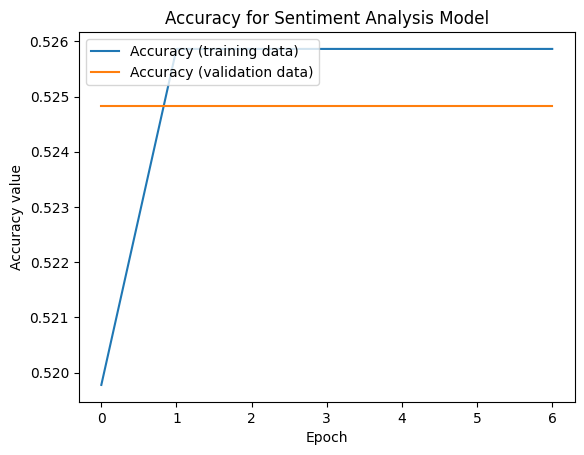

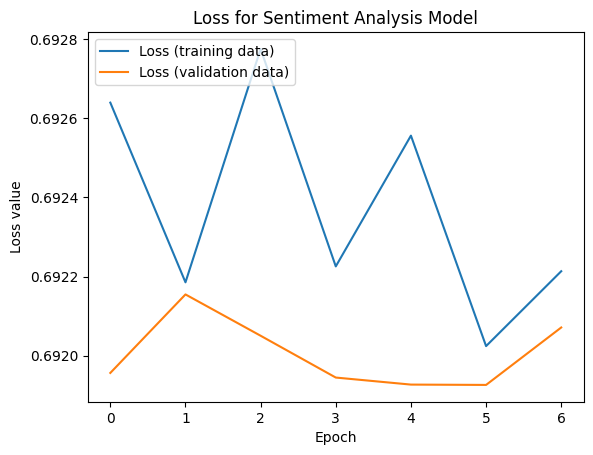

In [90]:
import matplotlib.pyplot as plt

plt.plot(model_lstm.history['accuracy'], label='Accuracy (training data)')
plt.plot(model_lstm.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Sentiment Analysis Model')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(model_lstm.history['loss'], label='Loss (training data)')
plt.plot(model_lstm.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Sentiment Analysis Model')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

Sieć CNN

In [65]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model_2.add(Conv1D(128, 5, activation='relu'))
model_2.add(GlobalMaxPooling1D())
model_2.add(Dense(1, activation='sigmoid'))
print(model_2.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 117, 50)           379200    
                                                                 
 conv1d_5 (Conv1D)           (None, 113, 128)          32128     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 411,457
Trainable params: 411,457
Non-trainable params: 0
_________________________________________________________________


None


In [66]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cnn = model_2.fit(X_train_tokens, y_train, epochs=3, validation_data=(X_val_tokens, y_val))

Epoch 1/3
62/62 [==============================] - 3s 33ms/step - loss: 0.6852 - accuracy: 0.5614 - val_loss: 0.6657 - val_accuracy: 0.6005
Epoch 2/3
62/62 [==============================] - 2s 29ms/step - loss: 0.6170 - accuracy: 0.7115 - val_loss: 0.6015 - val_accuracy: 0.6844
Epoch 3/3
62/62 [==============================] - 2s 29ms/step - loss: 0.4575 - accuracy: 0.8266 - val_loss: 0.5493 - val_accuracy: 0.7199


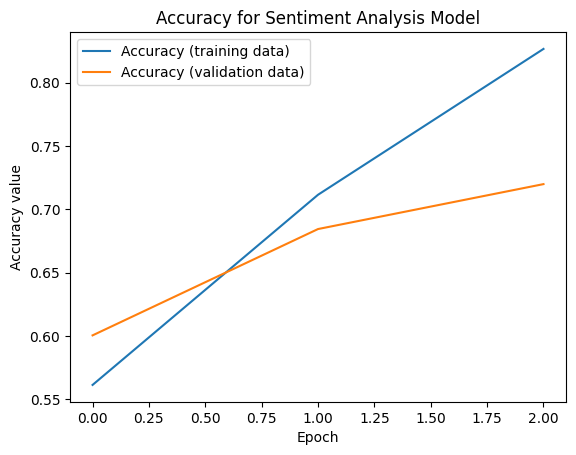

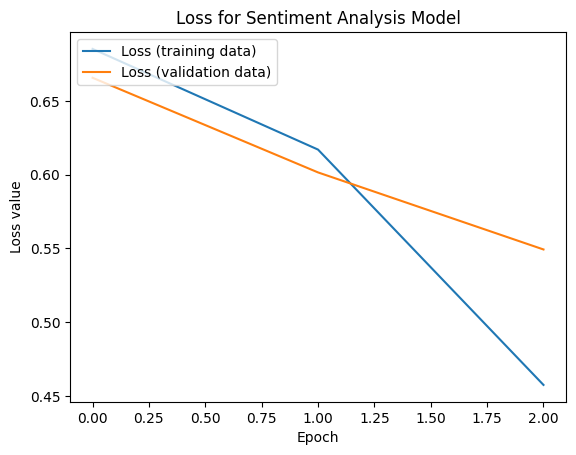

In [67]:
plt.plot(model_cnn.history['accuracy'], label='Accuracy (training data)')
plt.plot(model_cnn.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Sentiment Analysis Model')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(model_cnn.history['loss'], label='Loss (training data)')
plt.plot(model_cnn.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Sentiment Analysis Model')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

Podstawienie pre-trained word embeddingów

In [97]:
import gensim.downloader as api

word_vectors = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [101]:
import numpy as np

embedding_matrix = word_vectors.vectors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

model_3 = Sequential()
model_3.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_len, trainable=False)) 
model_3.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_word2vec = model_3.fit(X_train_tokens, y_train, validation_data=(X_val_tokens, y_val), epochs=5, batch_size=32)


Epoch 1/5
62/62 [==============================] - 38s 475ms/step - loss: 0.6920 - accuracy: 0.5218 - val_loss: 0.6921 - val_accuracy: 0.5248
Epoch 2/5
62/62 [==============================] - 28s 457ms/step - loss: 0.6922 - accuracy: 0.5259 - val_loss: 0.6915 - val_accuracy: 0.5248
Epoch 3/5
62/62 [==============================] - 30s 490ms/step - loss: 0.6915 - accuracy: 0.5259 - val_loss: 0.6912 - val_accuracy: 0.5248
Epoch 4/5
62/62 [==============================] - 30s 491ms/step - loss: 0.6902 - accuracy: 0.5259 - val_loss: 0.6913 - val_accuracy: 0.5248
Epoch 5/5
62/62 [==============================] - 31s 497ms/step - loss: 0.6917 - accuracy: 0.5198 - val_loss: 0.6916 - val_accuracy: 0.5248


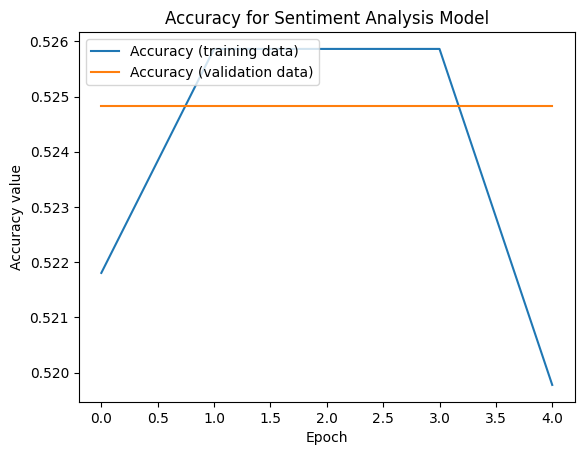

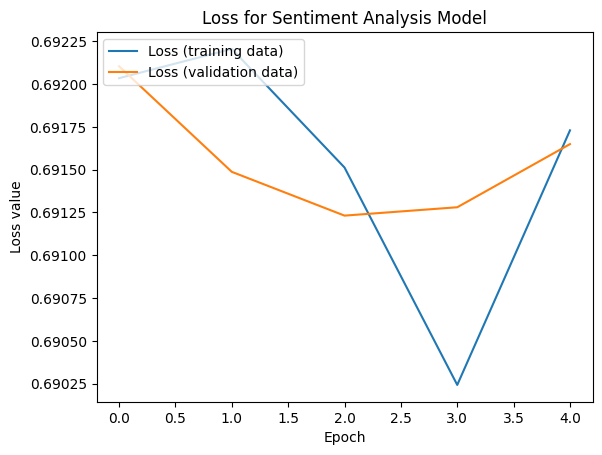

In [102]:
plt.plot(model_word2vec.history['accuracy'], label='Accuracy (training data)')
plt.plot(model_word2vec.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Sentiment Analysis Model')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(model_word2vec.history['loss'], label='Loss (training data)')
plt.plot(model_word2vec.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Sentiment Analysis Model')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

Fine-tuning modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

In [91]:
def prepare_sentence(sentence):

    sentence = sentence.lower()

    re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
    sentence = re_url.sub('', sentence)

    re_letter = re.compile(r"[^a-z\s']")
    sentence = re_letter.sub('', sentence)

    def remove_stopwords(text):
        return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

    sentence = remove_stopwords(sentence)

    def lemmatize(text):
        return ' '.join([x.lemma_ for x in nlp(text)])

    sentence = lemmatize(sentence)

    tokenized_sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(tokenized_sentence, maxlen=max_len, padding='post')

    return sentence

In [92]:
def predict_sentiment(model, sentence):
    
    prepared_sentence = prepare_sentence(sentence)
    prediction = model.predict(prepared_sentence)

    if prediction >= 0.5:
        return "I can sense STRESS in this sentence"
    else:
        return "All good don't sense ANY STRESS in here "

Wykorzystanie sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN

In [93]:
sentence = "I had a peaceful evening reading my favorite book."
result = predict_sentiment(model_1, sentence)
print(result)

1/1 [==============================] - 0s 477ms/step
I can sense STRESS in this sentence


Sieć CNN

In [94]:
sentence = "I had a peaceful evening reading my favorite book."
result = predict_sentiment(model_2, sentence)
print(result)

1/1 [==============================] - 0s 74ms/step
All good don't sense ANY STRESS in here 


Podstawienie pre-trained word embeddingów

In [ ]:
sentence = "I had a peaceful evening reading my favorite book."
result = predict_sentiment(model_3, sentence)
print(result)

Fine-tuning modelu języka (poza podstawowym BERTem)

In [ ]:
sentence = "I had a peaceful evening reading my favorite book."
result = predict_sentiment(model_4 sentence)
print(result)